# Download de imagens de Satélite utilizando GEE api em Python a partir de shapefile

Criação: Sabrina Paes Leme (paeslemesa@gmail.com) <br>
Data de criação: 03/04/2024 <br>

É necessário ter conta no __Google Earth Engine__ (GEE) para dar prosseguimento!

## 1. Importando bibliotecas

In [1]:
# 1. Bibliotecas relacionadas ao GEE
import ee # Biblioiteca Earth Engine
import geemap # Biblioteca Geemap

# 2. Bibliotecas auxiliares
import geopandas as gpd # Biblioteca de manipulação de dados geoespaciais
import numpy as np # Biblioteca de manipulação de arrays
from shapely.geometry import Polygon # Biblioteca de manipulação de geometrias
import rasterio # Biblioteca de manipulação de imagens raster
import os # Biblioteca de manipulação de arquivos
import  glob # Biblioteca de manipulação de arquivos
import requests # Biblioteca de requisições HTTP
import zipfile # Biblioteca de manipulação de arquivos zip


Aqui devemos autenticar a nossa conta do GEE. Vai abrir uma janela e você deve copiar e colar o código de autorização.

In [2]:
# 3. Autenticação no GEE
ee.Authenticate()

# 4. Inicialização do GEE
ee.Initialize()

## 2. Determinando as entradas

Aqui nós vamos inserir o caminho do nosso shapefile de entrada e as datas que queremos trabalhar.

Observação: o shapefile de entrada deve estar no sistema __EPSG:4326__

No caso do Sentinel-3, para cada banda, devemos utilizar um valor de escala de reflectância específico. Recomendo que você visite a página do catálogo do GEE para o Sentinel-3 para utilizar os fatores de escala corretos para a banda que você quer usar.

O Site é esse aqui: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S3_OLCI#bands

In [25]:
cam_shp = "D:/Pesquisa/Artigo_Mestrado/00_Dados/AOI.shp" # Caminho do shapefile inteiro (polígono)

data_ini = "2023-08-19" # Data de início da série temporal em formato "YYYY-MM-DD"
data_fim = "2023-08-20" # Data de fim da série temporal em formato "YYYY-MM-DD"

cam_saida = r"D:/Pesquisa/Artigo_Mestrado/01_Imagens/Sentinel3/DownloadGEE" # Caminho de saída das imagens
bandas = ["Oa04_radiance", # Azul - similar ao B2 do Sentinel-2
          "Oa06_radiance", # Verde - similar ao B3 do Sentinel-2
          "Oa08_radiance", # Vermelho - similar ao B4 do Sentinel-2
          "Oa17_radiance"] # NIR - próximo, mas não similar ao B8 do Sentinel-2
scales = [0.0115198, 0.0123538, 0.00876539, 0.00493004] 

### 2.1. Lendo o shapefile

In [4]:
geom = geemap.shp_to_ee(cam_shp) # Função para converter shapefile em geometria do GEE

# Abrindo a geometria em forma ee. Nesse caso, podemos perceber
#geom

## 3. Acessando ao catálogo de imagens do GEE


In [10]:
dataset = (
    ee.ImageCollection('COPERNICUS/S3/OLCI')
    .filterDate(data_ini, data_fim)
    .filterBounds(geom)
)

#dataset

Como o resutlado dessa busca foi só uma imagem, vou selecionar a primeira imagem do catálogo usando o comando <code>.first()</code>.

Depois disso, vou selecionar as bandas que eu quero trabalhar e aplicar o fator de escala para cada banda.

In [18]:
imagem = dataset.first().select(bandas).multiply(scales)

### 3.1. Visualizando os dados

Para visualizar a imagem que germos, vamos selecionar só as bandas RGB.

In [16]:
visualization = {
    'min': 0.0,
    'max': 0.8,
    'bands': ['Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance'],
}

m = geemap.Map()
m.centerObject(geom, 9)
m.add_layer(imagem.clip(geom), visualization, 'RGB')
m.addLayer(geom, {}, 'Área de Interesse')
m

Map(center=[-4.096530034134756, -53.78707564464392], controls=(WidgetControl(options=['position', 'transparent…

Você deve ver alguma coisa parecida com isso aqui:

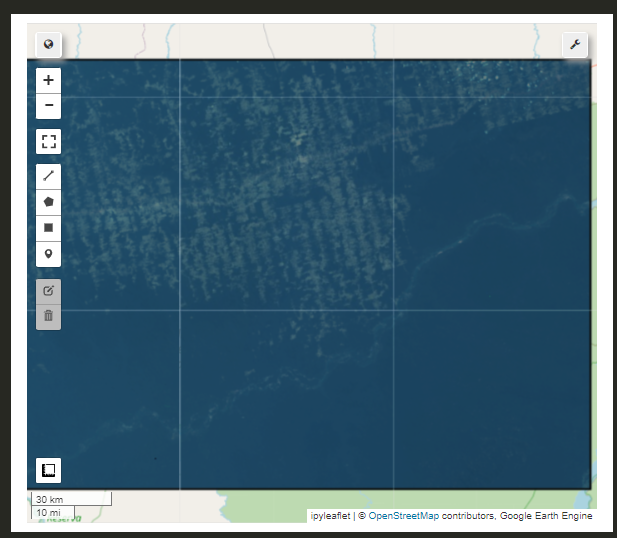

## 4. Baixando uma única imagem

Primeiro vamos determinar as coordenadas para baixar as imagens. É mais prático e rápido fazer usando o Geopandas.

In [17]:
gdf = gpd.read_file(cam_shp) # Lendo o shapefile
coords = gdf.geometry.bounds.values[0] # Pegando as coordenadas do shapefile

bbox = [[coords[0], coords[1]],
        [coords[0], coords[3]],
        [coords[2], coords[3]],
        [coords[2], coords[1]],
        [coords[0], coords[1]]]   

Neste momento, estamos determinando as configurações de download que usaremos.

A resolução original do Sentinel-3 OLCI é de 300 metros. Se você quiser reamostrar a imagem para uma outra resolução, basta alterar o valor de saída em <code>scale</code> aqui na configuração da tarefa.

In [19]:
configuracao_tarefa = {"image" : imagem, # Imagem que será exportada
                       "description" : "Sentinel3", # uma descrição qualquer
                       "region" : bbox, # Bounding Box da área de interesse
                       "scale" : 300, # resolucao em metros
                       "crs": 'EPSG:4326', # CRS de saída, pode alterar aqui para o CRS desejado
                       "fileNamePrefix": imagem.id().getInfo(), # Prefixo do nome do arquivo
                       "fileFormat" : "GeoTIFF", # Formato do raster de saída
                       }


Vamos baixar a imagem separadas por bandas num arquivo ZIP a partir de uma URL e depois vamos unir todas as bandas numa imagem só.

Esta próxima célula é um compilado de funções para resumir o processo que estamos fazendo, de forma a utilizarmos essas funções com maior facilidade no futuro.

In [26]:
#----------------------------------------------------------------------------
# 1. DEFININDO NOMES DOS ARQUIVOS DE SAÍDA
#----------------------------------------------------------------------------
nome_zip = os.path.join(cam_saida, f"Sentinel3_{data_ini}_{data_fim}.zip") # Nome do arquivo zipado de saída,
arquivo_saida = os.path.join(cam_saida, f"Sentinel3_{data_ini}_{data_fim}.tif") # Nome do arquivo de saída

#----------------------------------------------------------------------------
# 2. FUNCÇÕES
#----------------------------------------------------------------------------

def download_zip(configuracao_tarefa, nome_zip):
    """
    Função para baixar um arquivo zipado de uma imagem do GEE
    :param configuracao_tarefa: Configuração da tarefa de exportação
    :param arquivo_saida: Caminho de saída do arquivo zipado

    """
    download_url = imagem.getDownloadURL(configuracao_tarefa)  # Pegando a URL de download

    resposta = requests.get(download_url) # Fazendo a requisição da URL

    with open(nome_zip, 'wb') as f: # Escrevendo o arquivo zipado
        f.write(resposta.content)

    # Agora você deve ter um arquivo zipado com a imagem que você solicitou no caminho de saída que você definiu
        
    # Este código abaixo descompacta o arquivo zipado
    with zipfile.ZipFile(nome_zip, 'r') as zip_file: # Abrindo o arquivo zipado
        zip_file.extractall(cam_saida)  # Extraindo o arquivo zipado


def juntando_imagens(cam_saida, arquivo_saida):
    """ 
    Função para juntar as bandas de imagens exportadas do GEE
    :param cam_saida: Caminho de saída das imagens exportadas
    :param arquivo_saida: Caminho de saída da imagem concatenada
    """
    # Agora vamos encontrar os tifs exportados do ZIP
    lista_imgs = glob.glob(os.path.join(cam_saida, "*.tif")) # Lista de arquivos tif no caminho de saída

    # Agora vamos criar um loop para abrir os arquivos tif e concatenar as bandas
    for i, arquivo in enumerate(lista_imgs): # Loop para abrir os arquivos TIF
        if i == 0:
            # Para a primeira imagem, vamos abrir o arquivo e pegar as informações de perfil
            with rasterio.open(arquivo) as src:
                perfil = src.profile # pegando informações de coordenadas e metadados da imagem
                img = src.read(1) # lendo a primeira banda
                img = img[np.newaxis,:,:] # adicionando uma dimensão ao array para concatenar as outras bandas
        else:
            # Para as demais imagens, vamos abrir o arquivo e concatenar as bandas
            with rasterio.open(arquivo) as src:
                img = np.concatenate((img, src.read(1)[np.newaxis,:,:]), axis=0) # concatenando as bandas


    # Como pegamos os metadados apenas de uma banda, precisamos atualizar o perfil com as informações de todas as bandas
    perfil.update({"count": img.shape[0]})

    # Agora vamos escrever o arquivo de saída
    with rasterio.open(arquivo_saida, 'w', **perfil) as dst: # Escrevendo o arquivo de saída
        dst.write(img) # Escrevendo as bandas

    print("Aruivo savo como: ", arquivo_saida.split("/")[-1]) # Mensagem de confirmação



In [30]:
download_zip(configuracao_tarefa, nome_zip) # Chamando a função para baixar o arquivo zipado
juntando_imagens(cam_saida, arquivo_saida) # Chamando a função para juntar as bandas

Aruivo savo como:  DownloadGEE\Sentinel3_2023-08-19_2023-08-20.tif
